In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import simpy
import scipy.stats as st
import pandas as pd
import copy

from simulation import Person,simulate

## Preguntas
- Cual es la media de la cantidad de tareas resultas siguiendo cada estrategia?

- Comparar que estrategia de administración de tiempo es mas productiva?
  - 24-6
  - 12-3
  - Free

- ¿Cuál es la distribución de la cantidad de tareas completadas en la ventana de tiempo de 480 minutos? Esto te permitiría entender cuánto varía el rendimiento de la persona.

- ¿Cómo afecta la duración de los descansos a la cantidad de tareas completadas? Podrías comparar las simulaciones con diferentes duraciones de descanso para ver si hay alguna diferencia significativa.

- ¿Cómo afectan las interrupciones a la cantidad de tareas completadas? Similar a la pregunta anterior, podrías comparar las simulaciones con y sin interrupciones.

- ¿Cuál es la distribución del tiempo entre tareas completadas? Esto te permitiría entender cómo se distribuye el tiempo de trabajo de la persona.

- ¿Cómo se correlacionan el número de descansos y el número de tareas completadas? Esto podría ayudarte a entender si tomar más descansos lleva a completar más tareas.

In [2]:
import copy

def get_prob(n, time, b_time=0, b_duration=0, interruptions=True):
    prob = pd.DataFrame({})
    
    for i in range(n):
        env = simpy.Environment()
        person = Person(env,'S', b_time, b_duration,interr= interruptions)
        env.run(until=time)
        env.event().succeed()
        env.event().succeed()
        env.event().succeed()
        
        # Data Collecting
        prob_row = pd.DataFrame({
            "work_to_work": [copy.copy(person.work_to_work)],
            "work_to_break": [copy.copy(person.work_to_break)],
            "work_to_interrupt": [copy.copy(person.work_to_interrupt)],
            
            "break_to_work": [copy.copy(person.break_to_work)],
            "break_to_interrupt": [copy.copy(person.break_to_interrupt)],
            
            "interrupt_to_work": [copy.copy(person.interrupt_to_work)],
            "interrupt_to_break": [copy.copy(person.interrupt_to_break)]
        })
        
        
        prob = pd.concat([prob,prob_row])

    aux = prob.apply(sum, axis=0)
    print(aux.keys())
    work_to_break = aux["work_to_break"]
    work_to_interrupt = aux["work_to_interrupt"]
    
    twork =  work_to_break + work_to_interrupt
    
    break_to_work = aux["break_to_work"]
    break_to_interrupt = aux["break_to_interrupt"]
    
    tbreak = break_to_work + break_to_interrupt
    
    interrupt_to_work = aux["interrupt_to_work"]
    interrupt_to_break = aux["interrupt_to_break"]
    
    tinterrupt = interrupt_to_break + interrupt_to_work
    
    print('trabajando -> descansando',work_to_break/twork)
    print('trabajando -> interrupcion',work_to_interrupt/twork) 
    print()
    
    print('descanso -> interrupcion', break_to_interrupt/tbreak)
    print('descansando -> trabajando', break_to_work/tbreak)
    print()
    
    print('interrumpido -> descansando', interrupt_to_break/tinterrupt)
    print('interrumpido -> trabajando', interrupt_to_work/tinterrupt)
    
    
    
    return prob
   
    

In [3]:
get_prob(1000,480)

Exception ignored in: <generator object Person.working at 0x14e983b50>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py", line 881, in _argcheck_rvs
    all_bcast = np.broadcast_arrays(*args)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x14eab8120>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/generic.py", line 6264, in __finalize__
    if all(bool(obj.attrs) for obj in other.objs):
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x14eab8510>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/generic.py", line 6264, in __finalize__
    if all(bool(obj.attrs) for obj in other.objs):
RuntimeErro

Index(['work_to_work', 'work_to_break', 'work_to_interrupt', 'break_to_work',
       'break_to_interrupt', 'interrupt_to_work', 'interrupt_to_break'],
      dtype='object')
trabajando -> descansando 0.27455779016234555
trabajando -> interrupcion 0.7254422098376545

descanso -> interrupcion 0.3722089866474597
descansando -> trabajando 0.6277910133525403

interrumpido -> descansando 0.1832664975311673
interrumpido -> trabajando 0.8167335024688327


,work_to_work,work_to_break,work_to_interrupt,break_to_work,break_to_interrupt,interrupt_to_work,interrupt_to_break
0,11,9,32,9,9,32,9
0,12,7,29,7,6,29,6
0,6,9,35,9,7,35,7
0,8,11,23,11,3,23,3
0,6,11,25,11,11,25,11
...,...,...,...,...,...,...,...
0,9,9,34,9,6,34,6
0,19,9,23,9,8,23,8
0,9,9,38,9,7,38,7
0,4,9,31,9,8,31,8


In [20]:
import numpy as np

# Definición de las probabilidades de transición basadas en los datos proporcionados
P = np.array([
    [0, 0.27528568991983626, 0.7247143100801637],
    [0.624716615980094, 0, 0.375283384019906],
    [0.814207500684369, 0.185792499315631, 0]
])

def markov_chains_simulate(Num, P):
    #variables contadoras
    interruptions = 0
    completed_tasks = 1
    breaks = 0

    # Estado inicial del trabajador
    state = 'W'

    # Lista para almacenar los estados a lo largo de la simulación
    simulation = []

    for _ in range(Num):
        if state == 'W':
            r = np.random.rand()
            if r < P[0, 0]:
                state = 'W'
            elif r < P[0, 0] + P[0, 1]:
                state = 'D'
            else:
                state = 'I'

        elif state == 'D':
            r = np.random.rand()
            if r < P[1, 0]:
                state = 'W'
            else:
                state = 'I'

        else:  # Estado I
            r = np.random.rand()
            if r < P[2, 0]:
                state = 'W'
            else:
                state = 'D'

        if state == 'W':
            completed_tasks += 1
        elif state == 'D':
            breaks += 1
        else:
            interruptions += 1
        
        simulation.append(state)
        
    return simulation, completed_tasks, breaks, interruptions


simulation, completed_tasks, breaks, interruptions = markov_chains_simulate(100, P)

# Imprimir los resultados de la simulación
print("Estados a lo largo de la simulación:", simulation)
print(completed_tasks, breaks, interruptions)
total = completed_tasks + breaks + interruptions
print(completed_tasks/total, breaks/total, interruptions/total)


Estados a lo largo de la simulación: ['I', 'W', 'I', 'W', 'D', 'I', 'W', 'D', 'I', 'W', 'I', 'W', 'D', 'W', 'I', 'W', 'I', 'W', 'I', 'D', 'W', 'I', 'D', 'W', 'D', 'W', 'I', 'D', 'I', 'D', 'W', 'D', 'W', 'D', 'I', 'D', 'W', 'I', 'W', 'I', 'W', 'I', 'D', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'D', 'I', 'W', 'I', 'W', 'D', 'W', 'I', 'D', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'D', 'I', 'W', 'D', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'D', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'I', 'W', 'D', 'W']
43 19 39
0.42574257425742573 0.18811881188118812 0.38613861386138615


## Extracting Data


In [5]:

df_rand= simulate(30, 480, likelihood=True)

aux = df_rand[['interruption_time','working_time','break_time','interruptions','breaks','completed_tasks']].apply(sum , axis=0)
total = (aux['interruption_time']/aux['interruptions']) + aux['working_time']/aux['completed_tasks'] + aux['break_time']/aux['breaks']
print(aux['working_time']/aux['completed_tasks']/total)
print(aux['break_time']/aux['breaks']/total)
print(aux['interruption_time']/aux['interruptions']/total)
df_rand.head()


Exception ignored in: <generator object Person.working at 0x14eaba570>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexing.py", line 1192, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x14eab8270>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/concat.py", line 314, in _get_combined_plan
    unit = JoinUnit(nb)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x14eab8b30>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/concat.py", line 314, in _get_combined_plan
    unit = JoinUnit(nb)
RuntimeError: generator ignored Gener

0.4189481757177237
0.3119648906618056
0.26908693362047076


,break_duration,break_timestamp,interruptions,completed_tasks,breaks,working_time,break_time,interruption_time
0,0,0,36,6,10,23.835462,53.749890,83.621562
0,0,0,37,10,12,40.325327,43.362048,158.283936
0,0,0,28,10,12,84.936358,46.447563,116.604588
0,0,0,35,8,14,41.682976,60.424870,96.813392
0,0,0,28,15,14,62.275051,49.869267,68.093631


Exception ignored in: <generator object Person.working at 0x119513a00>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 542, in broadcast_arrays
    if all(array.shape == shape for array in args):
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x1199b8510>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/api.py", line 102, in get_objs_combined_axis
    obs_idxes = [obj._get_axis(axis) for obj in objs]
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x1199b8cf0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py", line 881, in _argcheck_rvs
    all_bcast = np.broadcast_a

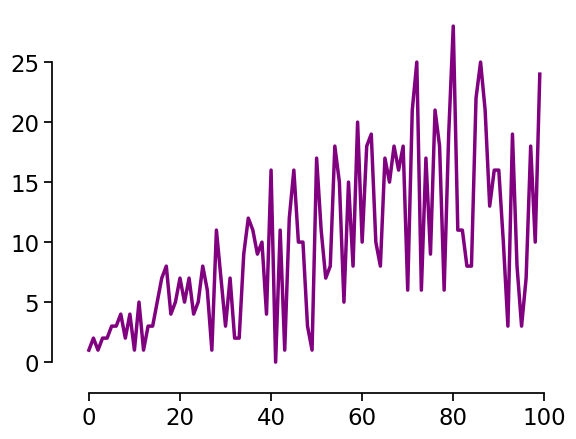

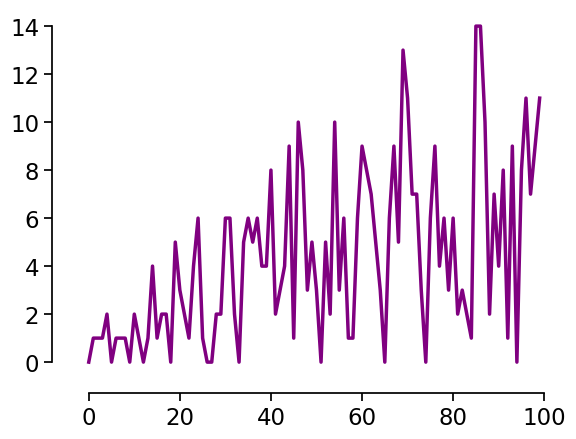

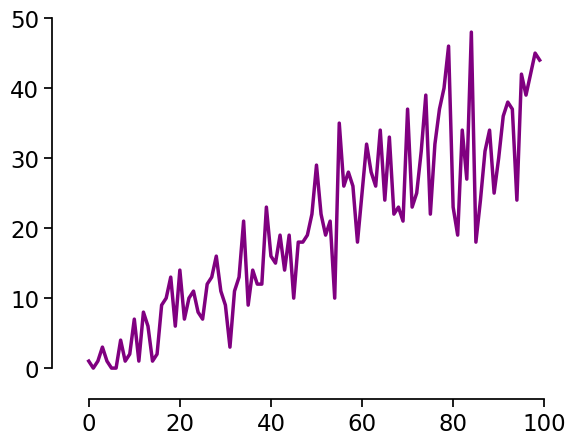

In [34]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

cts = []
ctm = []

bs =[]
bm = []

iS = [] 
iM = []

for i in range(100):
    df = simulate(1, (i+1)*10)
    sim, ct, b, interruptions  = markov_chains_simulate(i+1, P)

    ctm.append(ct)
    cts.append(df['completed_tasks'][0])

    bm.append(b)
    bs.append(df['breaks'][0])

    iM.append(interruptions)
    iS.append(df['interruptions'][0])

ctm= np.array(ctm)
cts = np.array(cts)

# sns.lineplot(x=range(100), y=cts, color = 'red', aplha=0.5)
# sns.lineplot(x=range(100), y=ctm, color = 'blue', aplha=0.5)
sns.lineplot(x=range(100), y=abs(cts - ctm), color = 'purple')
sns.despine(offset=10, trim=True)
plt.show()


bs= np.array(bs)
bm = np.array(bm)
# sns.lineplot(x=range(100), y=bs, color = 'red')
# sns.lineplot(x=range(100), y=bm, color = 'blue',ci=True)
sns.lineplot(x=range(100), y=abs(bs - bm), color = 'purple')
sns.despine(offset=10, trim=True)
plt.show()

iS= np.array(iS)
iM = np.array(iM)
# sns.lineplot(x=range(100), y=iS, color = 'red')
# sns.lineplot(x=range(100), y=iM, color = 'blue',ci=True)
sns.lineplot(x=range(100), y=abs(iS - iM), color = 'purple')
sns.despine(offset=10, trim=True)
plt.show()